In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


In [40]:
import pandas as pd
df = pd.read_csv("wildfires_greather_than_100acres_with_temperature.xls")

In [41]:
df.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_DESCR,FIRE_SIZE_CLASS,STATE,DATE,TMAX
0,2004,10/6/2004,280,Human,Equipment and vehicle use,38.523333,-120.211667,16823.0,USFS,G,CA,2004-10-06,21.3
1,2004,10/13/2004,287,Human,Power generation/transmission/distribution,38.780000,-120.260000,7700.0,USFS,G,CA,2004-10-13,24.7
2,2005,2/12/2005,43,Human,Debris and open burning,36.001667,-81.590000,125.0,MISSING/NOT SPECIFIED,D,NC,2005-02-12,10.5
3,2005,7/16/2005,197,Natural,Natural,43.899167,-102.954722,119.0,USFS,D,SD,2005-07-16,40.1
4,2005,7/16/2005,197,Natural,Natural,43.892778,-102.948056,119.0,USFS,D,SD,2005-07-16,39.7


In [42]:
year_col   = "FIRE_YEAR"      # year of fire
target_col = "FIRE_SIZE"      # burned area

feature_cols = [
    "LATITUDE",
    "LONGITUDE",
    "DISCOVERY_DOY",  # day of year (numeric)
    "TMAX",           # max temperature
]

In [43]:
df_model = df[[year_col, target_col] + feature_cols].dropna()
df_model

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,DISCOVERY_DOY,TMAX
0,2004,16823.0,38.523333,-120.211667,280,21.3
1,2004,7700.0,38.780000,-120.260000,287,24.7
2,2005,125.0,36.001667,-81.590000,43,10.5
3,2005,119.0,43.899167,-102.954722,197,40.1
4,2005,119.0,43.892778,-102.948056,197,39.7
...,...,...,...,...,...,...
60708,2019,9668.0,44.285050,-118.459800,221,20.4
60709,2020,401.0,36.303830,-94.903820,61,17.4
60710,2020,1000.0,26.191111,-81.523889,134,33.3
60711,2020,24892.0,46.670340,-120.114500,230,34.4


In [44]:
# 2. Outer temporal split:
#    Train = 1992–2015, Test = 2016–2020
train_mask = (df_model[year_col] >= 1992) & (df_model[year_col] <= 2015)
test_mask  = (df_model[year_col] >= 2016) & (df_model[year_col] <= 2020)

train_df = df_model.loc[train_mask].copy()
test_df  = df_model.loc[test_mask].copy()

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

In [45]:
# 3. Spatiotemporal BLOCKED CV on TRAINING data
#    - Region block: north vs south (latitude)
#    - Time block: early / mid / late within 1992–2015
#    - Each fold holds out one region-time block (LOGO)

# Spatial blocking: north (1) vs south (0)
lat_median = train_df["LATITUDE"].median()
train_df["region_block"] = np.where(train_df["LATITUDE"] >= lat_median, 1, 0)

# Temporal blocking: split training years into ~3 consecutive bins
# (early / mid / late 1992–2015)
train_df["time_block"] = pd.qcut(
    train_df[year_col],
    q=3,
    labels=False,
    duplicates="drop"
)

# Spatiotemporal block ID = combination of region and time block
train_df["block_id"] = (
    train_df["region_block"].astype(int) * 10
    + train_df["time_block"].astype(int)
)

groups = train_df["block_id"].values

logo = LeaveOneGroupOut()

print("Training samples:", X_train.shape[0])
print("Test samples:    ", X_test.shape[0])
print("Latitude median for north/south split:", lat_median)
print("Unique spatiotemporal blocks (train):", np.unique(groups))

Training samples: 10447
Test samples:     2375
Latitude median for north/south split: 38.83666667
Unique spatiotemporal blocks (train): [ 0  1  2 10 11 12]


In [46]:
# 4. Ridge Regression with blocked CV (LOGO)
ridge_alphas = np.logspace(-3, 3, 10)  # 0.001 → 1000

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

ridge_param_grid = {
    "ridge__alpha": ridge_alphas
}

ridge_grid = GridSearchCV(
    ridge_pipe,
    param_grid=ridge_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train, groups=groups)

ridge_best = ridge_grid.best_estimator_
print("\n=== Ridge Regression ===")
print("Best alpha:", ridge_grid.best_params_["ridge__alpha"])

y_pred_ridge = ridge_best.predict(X_test)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Test RMSE:", ridge_rmse)
print("Test R^2 :", ridge_r2)



=== Ridge Regression ===
Best alpha: 1000.0
Test RMSE: 27710.156994977537
Test R^2 : -0.002482854884416019


C:\Users\E R K PRADEEP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


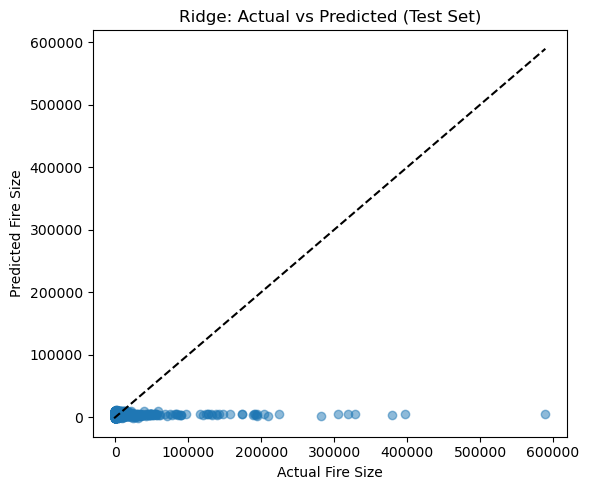

In [47]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--")
plt.xlabel("Actual Fire Size")
plt.ylabel("Predicted Fire Size")
plt.title("Ridge: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()

In [48]:
# 5. LASSO Regression with blocked CV (LOGO)
lasso_alphas = np.logspace(-3, 1, 10)  # 0.001 → 10

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=10000))
])

lasso_param_grid = {
    "lasso__alpha": lasso_alphas
}

lasso_grid = GridSearchCV(
    lasso_pipe,
    param_grid=lasso_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train, groups=groups)

lasso_best = lasso_grid.best_estimator_
print("\n=== LASSO Regression ===")
print("Best alpha:", lasso_grid.best_params_["lasso__alpha"])

y_pred_lasso = lasso_best.predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)
print("Test RMSE:", lasso_rmse)
print("Test R^2 :", lasso_r2)


=== LASSO Regression ===
Best alpha: 10.0
Test RMSE: 27710.99704131568
Test R^2 : -0.0025436372766818316


C:\Users\E R K PRADEEP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


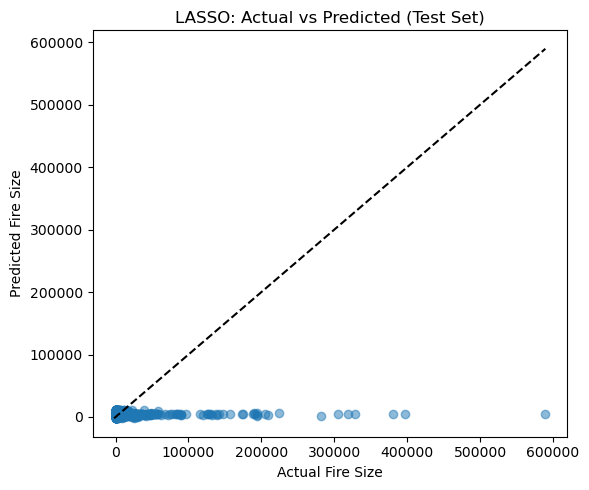

In [49]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--")
plt.xlabel("Actual Fire Size")
plt.ylabel("Predicted Fire Size")
plt.title("LASSO: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()

In [50]:
# 6. Elastic Net Regression  blocked CV (LOGO)
elastic_alphas = np.logspace(-3, 1, 8)  # 0.001 → 10
elastic_l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

elastic_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic", ElasticNet(max_iter=10000))
])

elastic_param_grid = {
    "elastic__alpha": elastic_alphas,
    "elastic__l1_ratio": elastic_l1_ratios
}

elastic_grid = GridSearchCV(
    elastic_pipe,
    param_grid=elastic_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

elastic_grid.fit(X_train, y_train, groups=groups)

elastic_best = elastic_grid.best_estimator_
print("\n=== Elastic Net Regression ===")
print("Best alpha   :", elastic_grid.best_params_["elastic__alpha"])
print("Best l1_ratio:", elastic_grid.best_params_["elastic__l1_ratio"])

y_pred_elastic = elastic_best.predict(X_test)
elastic_rmse = mean_squared_error(y_test, y_pred_elastic, squared=False)
elastic_r2 = r2_score(y_test, y_pred_elastic)
print("Test RMSE:", elastic_rmse)
print("Test R^2 :", elastic_r2)



=== Elastic Net Regression ===
Best alpha   : 0.7196856730011514
Best l1_ratio: 0.3
Test RMSE: 27713.39270172146
Test R^2 : -0.0027169877996575664


C:\Users\E R K PRADEEP\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


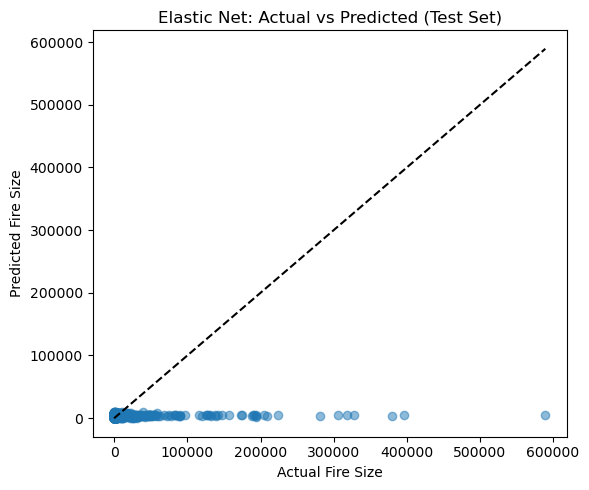

In [51]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_elastic, alpha=0.5)
min_val = min(y_test.min(), y_pred_elastic.min())
max_val = max(y_test.max(), y_pred_elastic.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--")
plt.xlabel("Actual Fire Size")
plt.ylabel("Predicted Fire Size")
plt.title("Elastic Net: Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.show()